This notebook kind of outlines some hacky code to use graphs to store the covalent connections pulled from a mmcif file (for exampel the pdb code 3ay4 mmcif file). The records are part of the 'struct_conn' dict that you can get from biopython's mmcif to dict parser.

Here, we are trying to use a graph to capture all of the connections betwee glycans specifically, for example in the case where we are interested in finding the ligand in a protein. We cannot use just the HETATM Records because the glycan's are included (even though they are not technically ligands that we are interested in). 

The idea demonstrated poorly here, is to create a graph of all of the covalent connections and traverse it to put the residues that are covalently attached to the protein into a 'do not keep' list. Then when we are parsing some pdb file, we can use the HETATM record as it will then correspond to only the ligand of interest, without the extra HETATM's (I think this will also help with modified Se-Cys residues?? not sure)

Also, this can be easily extended to create a graph for all of the atoms in the protein (just add edges between and N-C, C-Ca, Ca-N etc. Then you can search for the residues that are not connected to the largest graph. (Count number of nodes and subgraphs in the graph object, add the edges and connections from the struc_conn lines, the resulting smaller subgraph will be the ligand... just a thought)

In [8]:
# Get some data, here I use the 20 lines you sent me in and email, you should be able to just iter of the records in the struc_conn in the mmcif dict
data = []
with open('data','r') as fh:
    for line in fh:
        if line.startswith('coval'):
            print line
            data.append(line)

covale1  covale ? C ASN 160 ND2 ? ? ? 1_555 F NAG .   C1 ? ? C ASN 162  C NAG 1001 1_555 ? ? ? ? ? ? ? 1.408 ?

covale2  covale ? E MAN .   O2  ? ? ? 1_555 E NAG .   C1 ? ? B MAN 1007 B NAG 1008 1_555 ? ? ? ? ? ? ? 1.428 ?

covale3  covale ? D NAG .   O4  ? ? ? 1_555 D NAG .   C1 ? ? A NAG 1001 A NAG 1002 1_555 ? ? ? ? ? ? ? 1.431 ?

covale4  covale ? D BMA .   O6  ? ? ? 1_555 D MAN .   C1 ? ? A BMA 1003 A MAN 1007 1_555 ? ? ? ? ? ? ? 1.432 ?

covale5  covale ? D NAG .   O4  ? ? ? 1_555 D BMA .   C1 ? ? A NAG 1002 A BMA 1003 1_555 ? ? ? ? ? ? ? 1.432 ?

covale6  covale ? E NAG .   O4  ? ? ? 1_555 E BMA .   C1 ? ? B NAG 1002 B BMA 1003 1_555 ? ? ? ? ? ? ? 1.435 ?

covale7  covale ? A ASN 73  ND2 ? ? ? 1_555 D NAG .   C1 ? ? A ASN 297  A NAG 1001 1_555 ? ? ? ? ? ? ? 1.435 ?

covale8  covale ? D MAN .   O2  ? ? ? 1_555 D NAG .   C1 ? ? A MAN 1007 A NAG 1008 1_555 ? ? ? ? ? ? ? 1.436 ?

covale9  covale ? D MAN .   O2  ? ? ? 1_555 D NAG .   C1 ? ? A MAN 1004 A NAG 1005 1_555 ? ? ? ? ? ? ? 1

The cell below demonstrates the use of the networkx package. I like this package because it can a) be used on 10's of Millions of nodes b) is written in a compiled language and is fast and c) has all of the attributes that we care about using


I artificially create 5 residues connected, add edges to represent connections, print the objects and then try 'edges_iter' to see how I can travers the graph. Finally I plot the simple tree topology

In [9]:
from Bio.PDB import *

cif_file = "/Users/Research/ContactCounter/pdbs/3ay4.cif"
mmcif_dict = MMCIF2Dict.MMCIF2Dict( cif_file )

conn_type = mmcif_dict["_struct_conn.conn_type_id"]
p1_chain_id = mmcif_dict["_struct_conn.ptnr1_auth_asym_id"]
p1_comp_id = mmcif_dict["_struct_conn.ptnr1_auth_comp_id"]
p1_seq_id = mmcif_dict["_struct_conn.ptnr1_auth_seq_id"]
p2_chain_id = mmcif_dict["_struct_conn.ptnr2_auth_asym_id"]
p2_comp_id = mmcif_dict["_struct_conn.ptnr2_auth_comp_id"]
p2_seq_id = mmcif_dict["_struct_conn.ptnr2_auth_seq_id"]

print conn_type

['disulf', 'disulf', 'disulf', 'disulf', 'disulf', 'disulf', 'disulf', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale', 'covale']


['Res2', 'Res3', 'Res1', 'Res4', 'Res5']
[('Res2', 'Res3'), ('Res2', 'Res1'), ('Res2', 'Res4'), ('Res4', 'Res5')]
{'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'A', 'HETATM': True} {'AtomType': 'C1', 'ResType': 'Gln', 'Chain': 'A', 'HETATM': True}
{'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'A', 'HETATM': True} {'AtomType': 'ND2', 'ResType': 'ASN', 'Chain': 'A', 'HETATM': False}
{'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'A', 'HETATM': True} {'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'B', 'HETATM': True}
{'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'B', 'HETATM': True} {'AtomType': 'C1', 'ResType': 'Man', 'Chain': 'B', 'HETATM': True}


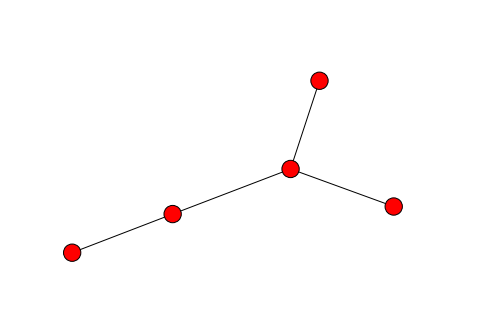

In [10]:
import networkx as nx
G=nx.Graph()  #create a graph (tree is a subset of a graph)


# each node has a name and then I pass a dict of values as attributes that are attached to the node
G.add_node('Res1', {'AtomType': 'ND2', 'Chain': 'A', 'ResType': 'ASN', 'HETATM' : False})
G.add_node('Res2', {'AtomType': 'C1', 'Chain': 'A', 'ResType': 'Man', 'HETATM' : True})
G.add_node('Res3', {'AtomType': 'C1', 'Chain': 'A', 'ResType': 'Gln', 'HETATM' : True})
G.add_node('Res4', {'AtomType': 'C1', 'Chain': 'B', 'ResType': 'Man', 'HETATM' :True})
G.add_node('Res5', {'AtomType': 'C1', 'Chain': 'B', 'ResType': 'Man', 'HETATM' :True})

G.add_edge('Res1','Res2')  # Add a bond between Res1 and Res2
G.add_edge('Res4','Res5')
G.add_edge('Res2','Res4')
G.add_edge('Res2','Res3')


print(G.nodes())  # each node is a unique residue (we are ignoring the atom for now
print(G.edges()) # each edge is a covalent bond

# iter of graph to look for edges that are connected to both protein and hetatm
for n1, n2 in G.edges_iter():
    print G.node[n1], G.node[n2]
    
import matplotlib.pyplot as plt
%matplotlib inline

val_map = {'Res1': 1.0,'Res2': 1.0,'Res3': 1.0,'Res4':1.0,'Res5':1.0}
values = [val_map.get(node, 0.25) for node in G.nodes()]
nx.draw(G)
plt.show()

# Below show's how to condition on attributes in the nodes

#    if (G.node[n1]['HETATM'] == True) or (G.node[n2]['HETATM'] == True):    
#        if (G.node[n1]['HETATM'] == False) or (G.node[n2]['HETATM']==False):
#            print "Found a Protein to HETATM connection in the struct_conn record! Possible Glycan"
#            print n1, n2
#            print G.node[n1]['ResType'], G.node[n2]['ResType']  
# iter over set of graph objects (that way we only add new graphs)

Now I define a class to parse the lines of the data, you shouldn't need this because you will have the mmcif dict. 

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import networkx

class struc_conn(object):
    def __init__(self,line):
        arr = line.split()
        type1 = arr[0]
        type2 = arr[1]
        self.covalent1 = True if type1.startswith('covale') else False
        self.covalent2 = True if type2.startswith('covale') else False
        self.chain1 = arr[17]
        self.restype1 = arr[18]
        self.resnum1 = arr[19]
        self.chain2 = arr[20]
        self.restype2 = arr[21]
        self.resnum2 = arr[22]
        self.atomtype1 = arr[6]
        self.atomtype2 = arr[14]
    
    def __repr__(self):
        return ' Chain %s, Res %s, Resname %s, Atom %s is connected to Chain %s, Res %s, Resname %s, Atom %s ' %(self.chain1, self.resnum1, self.restype1, self.atomtype1,self.chain2, self.resnum2, self.restype2, self.atomtype2) 

Below we create a graph to hold all of our nodes. As we loop over the struc_conn records we add edges. I also use a hash as the unique name instead of some shitty thing like resnum+chain+restype+ etc. A hash takes a length of bits L and returns a unique set of bits to describe those L bits. Basically this is just a way to get unique identifiers for each node. I want a node to be the individual resides and not the actually atoms (I'm making a graph of residues instead of a graph of atoms here).

For each line, I check to see if the node already exists ( I think networkx will let you overwrite an existing node, so that's why I do this.) Then I add the nodes and edges and plot it. Each subgraph is plotted in a different color. You can iter over each subgraph and get the attributes like the res number and chain and restype

One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues was already added to a graph, finding and adding to that graph now
One of these residues

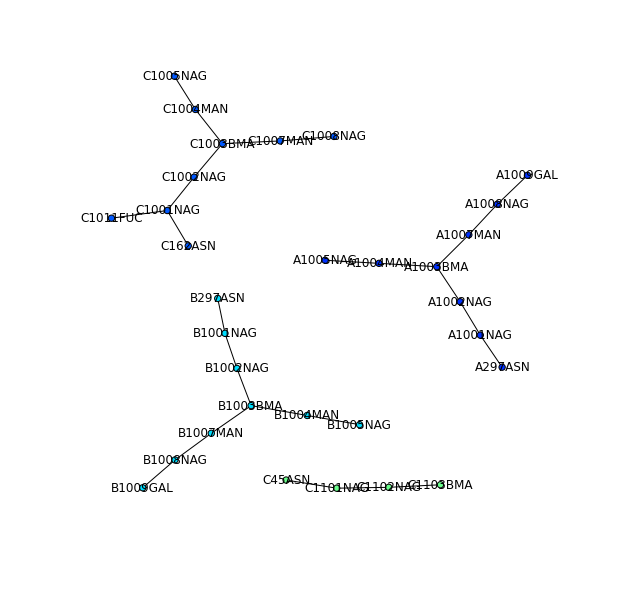

In [13]:
G=nx.Graph()
myhashset = set()
for line in data:
        #print line
        sc = struc_conn(line)
        #print sc
        myhash1 = (sc.chain1 + sc.resnum1 + sc.restype1)
        myhash2 = (sc.chain2 + sc.resnum2 + sc.restype2)
        if (myhash1 in myhashset) or (myhash2 in myhashset):
            print "One of these residues was already added to a graph, finding and adding to that graph now"
            #check find node and add edge to the graph          
            for n1, n2 in G.edges_iter():
                # IF the res node is already there, add the other one, and add the edge
                    try:
                        if (G.node[myhash1]):
                            G.add_node( myhash2, {'AtomType': sc.atomtype2, 'Chain': sc.chain2, 'ResType': sc.restype2, 'ResidueNumber' : sc.resnum2})
                            G.add_edge(myhash1,myhash2)
                    except:
                        pass
                    try:
                        if (G.node[myhash2]):
                            G.add_node( myhash1, {'AtomType': sc.atomtype1, 'Chain': sc.chain1, 'ResType': sc.restype1, 'ResidueNumber' : sc.resnum1})
                            G.add_edge(myhash1,myhash2)
                    except:
                        pass
        else:
            G.add_node( myhash2, {'AtomType': sc.atomtype2, 'Chain': sc.chain2, 'ResType': sc.restype2, 'ResidueNumber' : sc.resnum2})
            G.add_node( myhash1, {'AtomType': sc.atomtype1, 'Chain': sc.chain1, 'ResType': sc.restype1, 'ResidueNumber' : sc.resnum1})
            G.add_edge(myhash1,myhash2)
            
        myhashset.add(myhash1)
        myhashset.add(myhash2)

print myhashset
print G

plt.figure(1,figsize=(8,8))
    # layout graphs with positions using graphviz neato
pos=nx.graphviz_layout(G,prog="neato")
    # color nodes the same in each connected subgraph
C=nx.connected_component_subgraphs(G)
for g in C:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    nx.draw(g,pos,node_size=40,node_color=c,vmin=0.0,vmax=1.0,with_labels=True)
    
    #print G
plt.show()

In [61]:
C=nx.connected_component_subgraphs(G)
removethese = set()
for g in C:
    print g.nodes()
    worthwhile = False
    for n1, n2 in g.edges_iter():
        if g.node[n1]["AtomType"] or g.node[n2]["AtomType"]:
            worthwhile = True
    if worthwhile:
        for mynode in g.nodes_iter():
            removethese.add( mynode )
print
print removethese

['B1001NAG', 'B1003BMA', 'B1002NAG', 'B297ASN', 'B1009GAL', 'B1005NAG', 'B1008NAG', 'B1007MAN', 'B1004MAN']
['A1005NAG', 'A1003BMA', 'A1009GAL', 'A1002NAG', 'A1001NAG', 'A1004MAN', 'A1007MAN', 'A1008NAG', 'A297ASN']
['C162ASN', 'C1001NAG', 'C1011FUC', 'C1002NAG', 'C1005NAG', 'C1007MAN', 'C1004MAN', 'C1008NAG', 'C1003BMA']
['C1103BMA', 'C1102NAG', 'C45ASN', 'C1101NAG']

set(['B1003BMA', 'A1003BMA', 'A1009GAL', 'C1002NAG', 'A1001NAG', 'B297ASN', 'B1009GAL', 'A1007MAN', 'A1008NAG', 'C162ASN', 'B1001NAG', 'B1002NAG', 'C1102NAG', 'B1007MAN', 'A1004MAN', 'B1004MAN', 'A1005NAG', 'C1103BMA', 'C1101NAG', 'C1007MAN', 'C1004MAN', 'C45ASN', 'A297ASN', 'C1001NAG', 'C1005NAG', 'A1002NAG', 'C1011FUC', 'B1005NAG', 'B1008NAG', 'C1008NAG', 'C1003BMA'])
